<img align="left" src="https://iili.io/HXJBlj9.jpg" style="height:90px" style="width:30px"/>
<br>

# <a id='toc1_'></a>[Fundamentals of Supervised Machine Learning: Logistic Regression](#toc0_)
This notebook focuses on creating synthetic datasets for logistic regression, demonstrating hyperparameter tuning, analyzing model performance through confusion matrices, and conducting a technical analysis with statsmodels.api. It includes in-depth statistical evaluations, detailed analyses of deviance residuals, comparisons of full and reduced models, and interpretations of coefficients in terms of log odds and odds ratios. The project emphasizes the importance of choosing the right model based on metrics such as Log-Likelihood, AIC, and BIC, evaluates the reduced model's performance on test data, and discusses the interpretation of coefficients, AIC versus residual deviance, and decision boundaries. The notebook is designed to provide a comprehensive understanding of logistic regression analysis, balancing model accuracy and complexity. Prior knowledge in linear regression proves advantageous before delving into logistic regression.

**Table of contents**<a id='toc0_'></a>    
- [Fundamentals of Supervised Machine Learning: Logistic Regression](#toc1_)    
- [Dataset Introduction](#toc2_)    
  - [Generate Dataset](#toc2_1_)    
- [Data Preprocessing](#toc3_)    
  - [Train/Test Split](#toc3_1_)    
  - [Reshape](#toc3_2_)    
- [Logistic Regression with `sklearn`](#toc4_)    
  - [Hyperparameter Tuning](#toc4_1_)    
  - [Model Evaluation](#toc4_2_)    
    - [Confusion Matrix](#toc4_2_1_)    
    - [Classification Report](#toc4_2_2_)    
    - [ROC-AUC](#toc4_2_3_)    
  - [Understanding Logistic Regression Basics](#toc4_3_)    
      - [Positive Class Predicted Probabilities](#toc4_3_1_1_)    
      - [From Probability to Log(Odds): Logit Function](#toc4_3_1_2_)    
      - [From Log(Odds) to Probability: Inverse Logit Function](#toc4_3_1_3_)    
- [Technical Analysis with `statsmodels.api`](#toc5_)    
  - [Training Data: Summary Analysis](#toc5_1_)    
    - [Full Model](#toc5_1_1_)    
    - [Reduced Model](#toc5_1_2_)    
    - [Model Comparison Summary](#toc5_1_3_)    
    - [Simplified Overview and Analysis of Log-Likelihood, AIC, and BIC](#toc5_1_4_)    
      - [Log-Likelihood (LL)](#toc5_1_4_1_)    
      - [Akaike Information Criterion (AIC)](#toc5_1_4_2_)    
      - [Bayesian Information Criterion (BIC)](#toc5_1_4_3_)    
      - [Key Takeaway](#toc5_1_4_4_)    
  - [Test Data: Evaluating the Inner Workings](#toc5_2_)    
    - [Full Model](#toc5_2_1_)    
    - [Reduced Model](#toc5_2_2_)    
    - [Understanding Coefficient Impact: Log Odds and Odds Ratios](#toc5_2_3_)    
    - [Interpreting the Marginal Effects of a Coefficient](#toc5_2_4_)    
    - [AIC vs Residual Deviance for Model Comparison](#toc5_2_5_)    
    - [Deviance Residuals](#toc5_2_6_)    
      - [Calculating Deviance Residuals](#toc5_2_6_1_)    
      - [Deviance Residual Analysis](#toc5_2_6_2_)    
      - [Visualizing Deviance Residuals: Precision of Predictive Modeling Across Class Boundaries](#toc5_2_6_3_)    
    - [Decision Boundary](#toc5_2_7_)    
    - [Log Loss Explained / Binary Cross Entropy](#toc5_2_8_)    
- [Summary](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Dataset Introduction](#toc0_)
## <a id='toc2_1_'></a>[Generate Dataset](#toc0_)
The code below demonstrates the creation of a synthetic dataset with three features, visualized in 3D space. The `make_blobs` function from `sklearn.datasets` generates a total of 1000 data points divided into two clusters, each containing 500 points. These clusters are plotted in a 3D scatter plot to illustrate the class divisions.

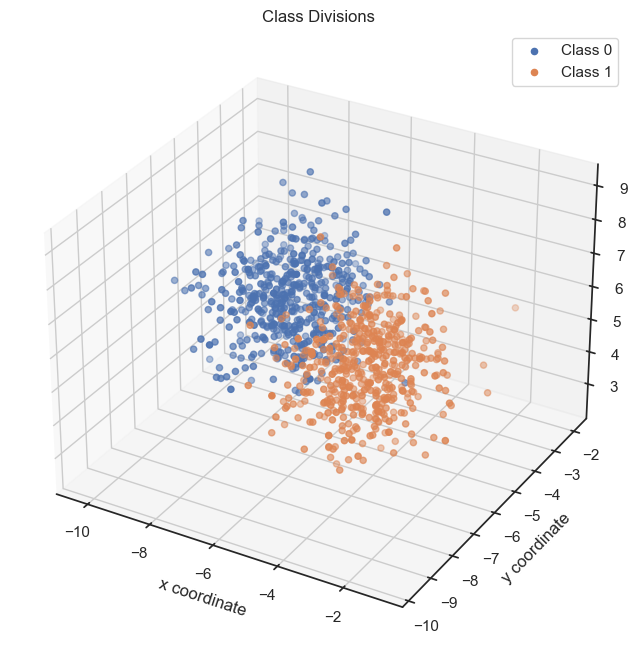

In [388]:
# Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns

sns.set_style("white")

# Generate synthetic data
coordinates, labels = make_blobs(n_samples=[500, 500], n_features=3, random_state=104)

# Visualize the data
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")

# Scatter plot for each class
for label in set(labels):
    indices = labels == label
    ax.scatter3D(coordinates[indices, 0], coordinates[indices, 1], coordinates[indices, 2], label=f'Class {label}')

# Setting labels and title
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title("Class Divisions")

# Display legend and Show plot
ax.legend()
plt.show()


In [389]:
# Convert coordinates and labels into a DataFrame
df = pd.DataFrame(coordinates).rename(columns={0:'x', 1:'y', 2:'z'})

# Add 'class' column to the DataFrame
df['class'] = labels

# Display the DataFrame
df

,x,y,z,class
0,-7.800351,-7.042705,5.963284,0
1,-4.048452,-7.293812,5.132414,1
2,-2.485358,-7.547218,4.970742,1
3,-4.381966,-6.730893,5.092438,1
4,-3.511412,-6.218532,4.869813,1
...,...,...,...,...
995,-6.969128,-7.313662,8.038005,0
996,-6.873303,-7.277550,5.182108,0
997,-3.050327,-6.345468,6.989217,1
998,-5.713515,-5.746681,6.731784,0


In [390]:
df['x']

0     -7.800351
1     -4.048452
2     -2.485358
3     -4.381966
4     -3.511412
         ...   
995   -6.969128
996   -6.873303
997   -3.050327
998   -5.713515
999   -1.982713
Name: x, Length: 1000, dtype: float64

In [391]:
# Check class balance
print("Class Balance")
df['class'].value_counts()

Class Balance


class
0    500
1    500
Name: count, dtype: int64

# <a id='toc3_'></a>[Data Preprocessing](#toc0_)
## <a id='toc3_1_'></a>[Train/Test Split](#toc0_)
The dataset is divided into training and test sets to assess the model's performance on unseen data, ensuring its generalization ability.

In [392]:
# Lib
from sklearn.model_selection import train_test_split

# Extract features (X) and target variable (y)
X, y = df.drop(columns=['class']).values, df['class'].values

# Define test size for data split
test_size = 0.2

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_size, 
                                                    random_state=42)

# Print shapes of training and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 3)
(800,)
(200, 3)
(200,)


## <a id='toc3_2_'></a>[Reshape](#toc0_)
Targets reshaped to 2D for model pipeline compatibility.

In [393]:
# Reshape targets to 2D for model pipeline
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(y_train.shape)
print(y_test.shape)

(800, 1)
(200, 1)


In [394]:
# Check shapes
print("x, y and z features")
X_train

x, y and z features


array([[-3.57205385, -6.53846528,  4.51723986],
       [-7.82292855, -4.15627348,  6.32517837],
       [-6.53364755, -4.84619888,  6.87946911],
       ...,
       [-7.31066575, -4.08908408,  7.49809961],
       [-7.3547211 , -4.4332569 ,  6.61663787],
       [-5.83712352, -5.53748925,  5.82786904]])

# <a id='toc4_'></a>[Logistic Regression with `sklearn`](#toc0_)

## <a id='toc4_1_'></a>[Hyperparameter Tuning](#toc0_)

Hyperparameter tuning refines a logistic regression model via:

- **`C`:** Modulates regularization strength inversely. Smaller values mean stronger regularization, reducing overfitting.
- **`penalty`:** Determines penalization norm. 'l1' results in sparse solutions, while 'l2' doesn't.
- **`solver`:** Chooses the optimization algorithm. 'liblinear' works well for small data sets; 'saga' for larger ones.
- **`tol`:** Sets the threshold for the stopping criterion. Training stops when loss improvement is below this value.

The provided code performs grid search cross-validation using these hyperparameters, showcasing the setup and execution of a systematic search for the most accurate logistic regression model configuration.
  
For an in-depth exploration of hyperparameter tuning, particularly solver options, reference this detailed [article](https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451).

In [395]:
# Import Libraries
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
        'logisticregression__C': [0.2, 0.3, 0.4],               # Inverse of regularization strength, smaller values imply stronger regularization i.e prevents overfitting..
        'logisticregression__penalty': ['l1', 'l2'],            # Specifies the norm used in the penalization (L1 produces sparse solutions).
        'logisticregression__solver': ['liblinear', 'saga'],    # Algorithm used for optimization problem i.e process of adjusting model parameters to fit the data as well as possible.
        'logisticregression__tol': [0.0001],                    # Sets stopping threshold for training, reducing computation time. Default: 0.0001.
        }

# Insantiate model
classifier = LogisticRegression(max_iter=5000)
pipe = make_pipeline(classifier)

# Perform CV hyperparameter search
grid_logreg = GridSearchCV(estimator=pipe,
                          param_grid=param_grid,
                          cv=5,
                          scoring='accuracy')

# Fit best estimator on training data
grid_logreg.fit(X_train, y_train.ravel())

# Print best accuracy score and corresponding parameters
print(f"Best score (Accuracy): {grid_logreg.best_score_}\n")
print(f"Best params: ")
_ = [print(f"{key}: {value}") for key, value in grid_logreg.best_params_.items()]

Best score (Accuracy): 0.95625

Best params: 
logisticregression__C: 0.3
logisticregression__penalty: l1
logisticregression__solver: saga
logisticregression__tol: 0.0001


In [396]:
# Score on test data
print(f"Test Score (Accuracy): {grid_logreg.score(X_test, y_test)}")

Test Score (Accuracy): 0.915


## <a id='toc4_2_'></a>[Model Evaluation](#toc0_)

### <a id='toc4_2_1_'></a>[Confusion Matrix](#toc0_)
The confusion matrix indicates that there are only 9 False Negatives and 8 False Positives among the other 184 observations that have been correctly classified. From this information, we can infer that not only is the accuracy high, but the precision and recall are also commendable.

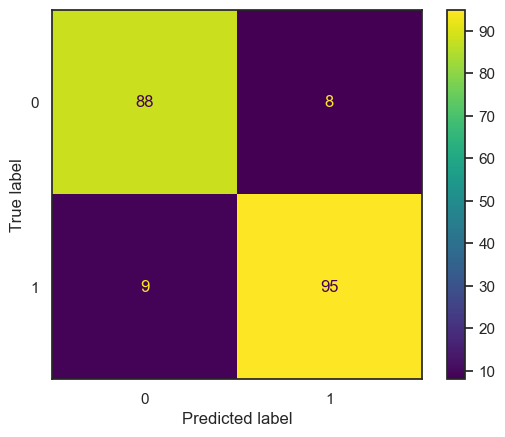

In [397]:
# Lib
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix using the fitted estimator (grid_logreg) and test data
ConfusionMatrixDisplay.from_estimator(grid_logreg, X_test, y_test)

# Display the plot
plt.show()

### <a id='toc4_2_2_'></a>[Classification Report](#toc0_)
The classification report validates our findings from the confusion matrix, confirming exceptionally high scores across all metrics. While accuracy remains our primary focus, we'll proceed to examine the ROC curve for further insights.

In [398]:
# Lib
from sklearn.metrics import classification_report

# Print classification report for the predictions on the test data
print(f"Classification Report")
print(classification_report(y_test, grid_logreg.predict(X_test)))

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        96
           1       0.92      0.91      0.92       104

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200



### <a id='toc4_2_3_'></a>[ROC-AUC](#toc0_)
The ROC curve graphically represents the trade-off between the true positive rate (recall) and false positive rate at various threshold settings. The area under the curve (AUC) of 0.98 signifies that the model has a 98% chance of correctly distinguishing between a randomly chosen positive instance and a randomly chosen negative instance. An AUC value close to 1 implies that the model has a high true positive rate and a low false positive rate across thresholds.

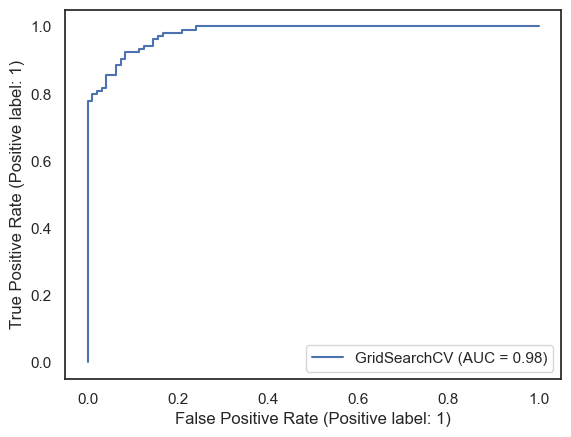

In [399]:
# Lib
from sklearn.metrics import RocCurveDisplay

# Plot ROC curve using the fitted estimator (grid_logreg) and test data
RocCurveDisplay.from_estimator(grid_logreg, X_test, y_test)

# Display the plot
plt.show()

---
## <a id='toc4_3_'></a>[Understanding Logistic Regression Basics](#toc0_)
The logistic regression model predicts the probability $(P)$ that a given observation falls into the positive class using the logistic function, which is defined as:

$$
P = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n)}}
$$

where:
- $P$ is the probability of the observation being in the positive class.
- $e$ is the base of the natural logarithm, approximately equal to 2.71828.
- $\beta_0$ is the intercept term.
- $beta_1, \beta_2, ..., \beta_n$ are the coefficients of the predictor variables $X_1, X_2, ..., X_n$, which quantify the impact of each predictor on the log(odds) of the outcome.
- $X_1, X_2, ..., X_n$ are the predictor variables.

The logistic function's beauty lies in its ability to transform the linear equation of predictors into a non-linear probability, ensuring all predictions stay within the 0 to 1 range, suitable for binary classification outcomes.

#### <a id='toc4_3_1_1_'></a>[Positive Class Predicted Probabilities](#toc0_)
Below are five observations with their model-predicted probabilities. A probability ≥0.5 categorizes an observation as the positive class.

In [400]:
# Obtain predicted probabilities for the observations from the fitted model
predicted_probabilities = grid_logreg.predict_proba(X_train)

# Convert predicted probabilities into a DataFrame for visualization
probabilities_df = pd.DataFrame(predicted_probabilities[:, 1], columns=['Predicted Probability'])

# Print the first few rows of the DataFrame
print(probabilities_df.head())

   Predicted Probability
0               0.998712
1               0.000210
2               0.015908
3               0.033497
4               0.001027


---
#### <a id='toc4_3_1_2_'></a>[From Probability to Log(Odds): Logit Function](#toc0_)
Converting the probability of the first observation into log(odds): 
<br><br>
$\text{Log(odds)} = \log\left(\frac{P}{1 - P}\right)$

In [401]:
# Assuming prob is the probability
prob = 0.998715

# Convert probability to log(odds)
log_odds = np.log(prob / (1 - prob))

print("Log(odds):", log_odds)

Log(odds): 6.655710734314512


#### <a id='toc4_3_1_3_'></a>[From Log(Odds) to Probability: Inverse Logit Function](#toc0_)
Converting log(odds) back to probability:
<br><br>
$P = \frac{e^{\text{Log(odds)}}}{1 + e^{\text{Log(odds)}}}$

In [402]:
# Assuming log_odds is the log(odds) value
log_odds = 6.655710734314512

# Convert log(odds) to probability
prob = np.exp(log_odds) / (1 + np.exp(log_odds))

print("Probability:", prob)

Probability: 0.998715


---
# <a id='toc5_'></a>[Technical Analysis with `statsmodels.api`](#toc0_)

This section delves into an in-depth statistical evaluation of logistic regression models using the `statsmodels` package. We compare full and reduced models, assess fit using metrics like Log-Likelihood, AIC, and McFadden's $R^2$, and interpret the implications of these statistics. Additionally, we calculate predicted probabilities and interpret model coefficients in terms of log odds. This rigorous approach quantifies fit and complexity, guiding informed decisions about model selection and ensuring robust predictive performance.


## <a id='toc5_1_'></a>[Training Data: Summary Analysis](#toc0_)
### <a id='toc5_1_1_'></a>[Full Model](#toc0_)
In the logistic regression 'Full Model' (FM), the coefficient for $x_{3}$ is not statistically significant, as indicated by its p-value. Consequently, our subsequent analysis will focus on comparing the FM—which includes $x_{3}$—with the 'Reduced Model' (RM) that omits this variable.

**Note**: The LLR p-value for this FM and the subsequent RM consistently indicates a significant improvement over the null model, which includes only the intercept. This suggests that our predictors meaningfully enhance model fit. Future model comparisons will assume this established significance and not revisit the LL-Null or LLR p-value specifics.

In [403]:
# Lib
import statsmodels.api as sm

# Add constant column to the train feature matrix
X_train = sm.add_constant(X_train)

# Fit logistic regression model to the train data
model = sm.Logit(y_train, X_train).fit()

# Print summary of the fitted full model for the train data
print("\nFull Model - Train Data")
print(model.summary())

# Calculate and print AIC and BIC
aic = model.aic  # Akaike Information Criterion
bic = model.bic  # Bayesian Information Criterion
print(f"\nAIC: {aic}")
print(f"BIC: {bic}")

Optimization terminated successfully.
         Current function value: 0.123269
         Iterations 9

Full Model - Train Data
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      796
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.8221
Time:                        18:32:13   Log-Likelihood:                -98.615
converged:                       True   LL-Null:                       -554.48
Covariance Type:            nonrobust   LLR p-value:                2.533e-197
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6044      2.091      6.986      0.000      10.507      18.702
x1  

---
### <a id='toc5_1_2_'></a>[Reduced Model](#toc0_)

The reduced model below excludes feature $x_{3}$, representing the z-axis values in a 3D plot.

**McFadden's Pseudo $R^2$:** A metric that quantifies the explanatory power of a logistic regression model

**Mathematical Formulation:** McFadden's Pseudo $R^2$ is calculated as $1 - \frac{\log(L_{model})}{\log(L_{null})}$, where $L_{model}$ is the log-likelihood of the fitted model and $L_{null}$ is the log-likelihood of the null model, which includes only the intercept.

**Interpretation of $R^2$:** Unlike in linear regression, where $R^2$ represents the proportion of variance explained by the model, logistic regression uses a pseudo $R^2$ to gauge the model's explanatory power. A pseudo $R^2$ value of 0.819 signifies a strong model fit.

**Model Comparison Summary:** Comparisons further below will leverage log-likelihood and Akaike Information Criterion (AIC) metrics, providing a nuanced view of model performance and complexity.

In [404]:
# Extract features from train data excluding the last column containing the z-feature
X_train_no_z = X_train[:, :-1]

# Fit logistic regression model to the train data
model_no_z = sm.Logit(y_train, X_train_no_z).fit()

# Print summary of the fitted model for the reduced dataset
print("\nReduced Model (w/o x3) - Train Data")
print(model_no_z.summary())

# Calculate and print AIC and BIC
aic_no_z = model_no_z.aic  # Akaike Information Criterion
bic_no_z = model_no_z.bic  # Bayesian Information Criterion
print(f"\nAIC: {aic_no_z}")
print(f"BIC: {bic_no_z}")

Optimization terminated successfully.
         Current function value: 0.125454
         Iterations 9

Reduced Model (w/o x3) - Train Data
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.8190
Time:                        18:32:13   Log-Likelihood:                -100.36
converged:                       True   LL-Null:                       -554.48
Covariance Type:            nonrobust   LLR p-value:                6.036e-198
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7915      1.751      7.304      0.000       9.359     

### <a id='toc5_1_3_'></a>[Model Comparison Summary](#toc0_)
Following is a succinct comparison between the Full Model (FM) and the Reduced Model (RM):
- **Model Fit**: Both models show strong fit. The FM exhibits slightly higher Pseudo R-squared and lower Log-Likelihood, indicating better fit to the training data.
- **Predictor Significance**: $x_{1}$ and $x_{2}$ are statistically significant in both models. Removing $x_{3}$ minimally impacts the model's fit, with a slight decrease in Pseudo R-squared and minimal increases in AIC and BIC.
- **Model Complexity**: The RM is simpler, excluding the marginally significant $x_{3}$, which has minimal impact on model performance.
- **Decision Criteria**: Choosing between models may hinge on simplicity versus fit. The FM offers slightly better fit, while the RM provides simplicity without sacrificing predictive power.


### <a id='toc5_1_4_'></a>[Simplified Overview and Analysis of Log-Likelihood, AIC, and BIC](#toc0_)

To choose the best model in logistic regression, we can look at several other statistics:

#### <a id='toc5_1_4_1_'></a>[Log-Likelihood (LL)](#toc0_)
- **What it is**: A measure of fit; higher values mean a better fit.
- **Math**: $ LL = \sum [ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) ] $
- **Notation Explanation**: 
  - $y_i$: Actual outcome for observation i.
  - $\hat{y}_i$: Predicted probability of observation i belonging to the positive class.
- **Interpretation**: For a correct prediction (class 1 with probability 0.6), the contribution to LL is $\log(0.6)$, which is approximately -0.51. If the prediction is incorrect (class 0 with probability 0.6), the contribution is $\log(1-0.6)$, or approximately -0.92. Lower LL values (further from 0) indicate more inaccurate predictions; hence, a higher LL (closer to 0) denotes a better model.

#### <a id='toc5_1_4_2_'></a>[Akaike Information Criterion (AIC)](#toc0_)
- **What it is**: Balances fit and simplicity; lower values are better.
- **Math**: $ AIC = -2 \cdot LL + 2 \cdot k $
- **Notation Explanation**:
  - $k$: Number of parameters in the model.
- **Interpretation**: The AIC values indicate a preference for the Full Model (FM) with an AIC of 205.23 over the Reduced Model (RM), which has an AIC of 206.73. Despite FM's additional parameter, its lower AIC highlights a superior trade-off between accuracy and model simplicity. The inclusion of $x_3$ in FM effectively improves model performance with minimal complexity cost, establishing FM as the favored model in this evaluation.

#### <a id='toc5_1_4_3_'></a>[Bayesian Information Criterion (BIC)](#toc0_)
- **What it is**: Like AIC, but with a stronger penalty for more parameters; lower values are better.
- **Math**: $ BIC = -2 \cdot LL + \log(n) \cdot k $
- **Notation Explanation**:
  - $n$: Number of observations in the dataset.
- **Interpretation**: The BIC comparison favors the Reduced Model (RM) over the Full Model (FM), as evidenced by RM's lower BIC value (220.78 vs. 223.97). BIC's stricter penalty on complexity suggests RM offers an optimal balance between simplicity and fit, making it the preferred choice according to BIC standards.

#### <a id='toc5_1_4_4_'></a>[Key Takeaway](#toc0_)
LL, AIC, and BIC guide us in model selection, weighing accuracy against complexity. The Full Model, with better LL and marginally lower AIC, is slightly better, indicating a closer fit to the data's true pattern. However, if interpretability and simplicity are paramount, the Reduced Model might be preferable, given its lower BIC.


---
## <a id='toc5_2_'></a>[Test Data: Evaluating the Inner Workings](#toc0_)

In the upcoming segment, we will delve deeper into the intricacies of logistic regression.
We evaluate the reduced model on the test data, focusing on:

- **Coefficients Interpretation**: 
    - **Log Odds**: Change in log odds with a one-unit change in the predictor.
    - **Odds Ratio**: The multiplicative change in odds for a one-unit increase in the predictor.
    - **Marginal Effects**: The change in probability with a one-unit change in the predictor.
- **AIC vs Residual Deviance**: AIC balances model fit and complexity, while residual deviance assesses goodness of fit.
- **Deviance Residuals**: Evaluation of model fit at the individual observation level.
- **Decision Boundaries**: Visualization of the model's classification threshold.
- **Log Loss / Binary Cross Entropy**: The model's performance measured by the loss function.


NOTE: While the full model excels in almost all aspects, here we specifically showcase the reduced model's performance concerning the aforementioned bullet points, primarily for educational purposes.

### <a id='toc5_2_1_'></a>[Full Model](#toc0_)
Presenting the test outcomes for the Full Model on the test dataset, we conclude it surpasses the Reduced Model. Subsequently, our technical analysis will proceed, focusing on the test data for the Reduced Model.

In [405]:
# Add constant column to the test feature matrix
X_test = sm.add_constant(X_test)

# Fit logistic regression model to the test data
model_test = sm.Logit(y_test, X_test).fit()

# Print summary of the fitted full model for the test data
print("\nFull Model - Test Data")
print(model_test.summary())

# Calculate and print AIC and BIC
aic_test = model_test.aic  # Akaike Information Criterion
bic_test = model_test.bic  # Bayesian Information Criterion
print(f"\nAIC: {aic_test}")
print(f"BIC: {bic_test}")

Optimization terminated successfully.
         Current function value: 0.147262
         Iterations 9

Full Model - Test Data
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.7873
Time:                        18:32:13   Log-Likelihood:                -29.452
converged:                       True   LL-Null:                       -138.47
Covariance Type:            nonrobust   LLR p-value:                 5.342e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.9618      4.731      4.431      0.000      11.690      30.234
x1   

### <a id='toc5_2_2_'></a>[Reduced Model](#toc0_)

In [406]:
# Extract features from test data excluding the last column containing the z-feature
X_test_no_z = X_test[:, :-1]

# Add constant column to the feature matrix
X_test_no_z = sm.add_constant(X_test_no_z)

# Fit logistic regression model on test data
model_no_z_test = sm.Logit(y_test, X_test_no_z).fit()

# Print summary of the fitted model for the reduced dataset
print("\nReduced Model (w/o x3) - Test Data")
print(model_no_z_test.summary())

# Calculate and print AIC and BIC
aic_no_z = model_no_z_test.aic  # Akaike Information Criterion
bic_no_z = model_no_z_test.bic  # Bayesian Information Criterion
print(f"\nAIC: {aic_no_z}")
print(f"BIC: {bic_no_z}")

Optimization terminated successfully.
         Current function value: 0.190730
         Iterations 9

Reduced Model (w/o x3) - Test Data
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Sun, 03 Mar 2024   Pseudo R-squ.:                  0.7245
Time:                        18:32:13   Log-Likelihood:                -38.146
converged:                       True   LL-Null:                       -138.47
Covariance Type:            nonrobust   LLR p-value:                 2.692e-44
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1888      2.874      3.894      0.000       5.557      

---
### <a id='toc5_2_3_'></a>[Understanding Coefficient Impact: Log Odds and Odds Ratios](#toc0_)
**For $x_{1}$**:
- **Coefficient (2.8437)**: A one-unit increase in $x_{1}$ raises the log odds of $Y=1$ by 2.8437, holding other predictors constant.
- **Odds Ratio (17.179)**: Each one-unit rise in $x_{1}$ multiplies the odds of $Y=1$ by about 17 times, with all else equal.


**Coefficient Interpretation**: The coefficient (log odds increase) helps in understanding the directional influence of $x_{1}$ on the likelihood of the positive outcome, essential for evaluating the strength and direction of predictor effects.
  
**Odds Ratio Utilization**: The odds ratio offers a relative measure of the effect, useful for quantifying how much more likely the positive outcome becomes with each unit increase in $x_{1}$. It's particularly valuable in contexts where understanding the magnitude of change, in a multiplicative sense, is important for decision-making or risk assessment.

Both metrics—coefficient and odds ratio—serve complementary roles in logistic regression analysis, facilitating a comprehensive understanding of predictor variables' effects on the outcome.


In [407]:
# Step 1: Extract coefficients from the fitted model
log_odds = model_no_z_test.params

# Step 2: Calculate odds ratios from the extracted coefficients
odds_ratios = np.exp(log_odds)

# Step 3: Create a DataFrame to display the coefficients and odds ratios
results_summary = pd.DataFrame({'Coefficient': log_odds, 'Odds Ratio': odds_ratios})

# Step 4: Print the results
print(results_summary)

   Coefficient    Odds Ratio
0    11.188781  72314.611495
1     2.843682     17.178900
2    -0.817722      0.441436


In [408]:
# Turns odds ratio back into log-odds
np.log(odds_ratios[1])

2.8436818775909627

### <a id='toc5_2_4_'></a>[Interpreting the Marginal Effects of a Coefficient](#toc0_)

**For $x_{1}$**:
- **Marginal Effect (0.1652)**: A one-unit increase in $x_{1}$ results in an approximate 16.52 percentage point increase in the probability of $Y=1$, holding other predictors constant (p-value: 0.000).
  
**Interpretation**:  
This illuminates how variations in $x_{1}$ directly translate into changes in the probability of the outcome, offering a clear grasp of its role. Unlike odds ratios, which reflect relative changes, this absolute measure assesses $x_{1}$'s practical impact on outcomes, enhancing interpretability for decision-making and communication.


In [409]:
# Obtain marginal effects summary for the fitted model
print(model_no_z_test.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1652      0.008     21.539      0.000       0.150       0.180
x2            -0.0475      0.016     -3.059      0.002      -0.078      -0.017


---
### <a id='toc5_2_5_'></a>[AIC vs Residual Deviance for Model Comparison](#toc0_)

- **AIC (Akaike Information Criterion)** offers a balance between model fit and complexity, penalizing excessive parameters:

  $$ AIC = -2 \cdot \text{Log-Likelihood} + 2 \cdot k $$

  Here, $k$ denotes the total number of estimated parameters.
  
<br>

- **Residual Deviance** reflects the goodness of fit alone, not penalizing for model complexity:

  $$ Residual Deviance = -2 \cdot \text{Log-Likelihood} $$

<br>

**Key Takeaways**:
- AIC is favored for model selection as it prevents overfitting by incorporating a penalty for the number of parameters.
- Lower AIC values suggest a model with a better trade-off between fit and simplicity.
- Residual Deviance can be used in conjunction with AIC or when comparing nested models using a likelihood ratio test.

<br><br>
**Note**: AIC often serves as the preferred metric for comparing models, offering a judicious balance between the quality of fit and the complexity of the model. It assists in selecting models that are adequately fitted to the data while maintaining a lean structure. This notebook specifically examines nested models, which involves adjusting a parameter in the more complex model to zero. Although such comparisons are common and pivotal in statistical analysis, they represent just one of many approaches to model evaluation. Our focus here is educational, designed to highlight foundational concepts. As such, we will not engage in a detailed comparison of residual deviances. However, it's worth noting that for the models discussed, a comparison based on residual deviances would similarly underscore the superiority of the full model, reinforcing the value of comprehensive model assessment techniques.

In [410]:
# Calculate residual deviance from the given log-likelihood
log_likelihood = -38.146
residual_deviance = -2 * log_likelihood

# Print residual deviance
print(f"Residual Deviance: {residual_deviance}")

# Print AIC from the fitted statsmodels object
print(f"\nAIC: {model_no_z_test.aic}")

Residual Deviance: 76.292

AIC: 82.29189980419355


---
### <a id='toc5_2_6_'></a>[Deviance Residuals](#toc0_)
#### <a id='toc5_2_6_1_'></a>[Calculating Deviance Residuals](#toc0_)
To obtain the deviance residual for an observation, we use the following formula:

$$d_i = \text{sign}(y_i - \hat{y}_i) \sqrt{2 \left[ y_i \cdot \log\left(\frac{y_i}{\hat{y}_i}\right) + (1 - y_i) \cdot \log\left(\frac{1 - y_i}{1 - \hat{y}_i}\right) \right]}$$

Where:
- $d_i$ is the deviance residual for the i-th observation,
- $y_i$ is the actual outcome for the i-th observation,
- $\hat{y}_i$ is the predicted probability for the i-th observation,
- $\log$ is the natural logarithm.

<br>
This formula simplifies to:

- **For the Positive Class** (where the observed outcome is 1):
  $$\text{Deviance Residual for Positive Class} = \sqrt{-2 \times \log(\text{predicted probability})}$$
<br>
- **For the Negative Class** (where the observed outcome is 0):
$$\text{Deviance Residual for Negative Class} = \sqrt{-2 \times \log(1 - \text{predicted probability})}$$

These steps are repeated for all predicted probabilities (likelihoods), culminating in a set of deviance residuals. This distribution offers insights into the fit of a logistic regression model at the individual observation level.

The following section illustrates the calculation of deviance residuals, focusing on the second and third predictions within the test dataset using the simplified formula.

In [411]:
# Predicted probabilities for second and third element
list(model_no_z_test.predict()[1:3])

[0.0018912161130351525, 0.9724277889730215]

In [412]:
# Two predicted probabilities from the model
predicted_probability = list(model_no_z_test.predict()[1:3])

for proba in predicted_probability:
    # Actual observed outcome 0 or 1
    if proba < 0.5:
        actual_outcome = 0
    else:
        actual_outcome = 1
        
    print(f"Deviance residual for observation with probability {proba:.4f}: ")

    # Calculate and display the deviance residual
    if actual_outcome == 1:
        print(np.sqrt(-2 * (np.log(proba))))
    else:
        print(-np.sqrt(-2 * (np.log(1 - proba))))
    print("")

Deviance residual for observation with probability 0.0019: 
-0.06153058946899704

Deviance residual for observation with probability 0.9724: 
0.2364718132482794



In [413]:
# Deviance residuals of interest calculated directly from the model
deviance_residuals[1:3]

array([-0.06153059,  0.23647181])

#### <a id='toc5_2_6_2_'></a>[Deviance Residual Analysis](#toc0_)
Deviance residuals offer insight into the fit of a logistic regression model at the individual observation level. Here's a concise analysis:

- **Range**: Residuals range from approximately -2.1062 to 1.9405, indicating variability in predictive performance.
- **Quartiles**: The 1st and 3rd quartiles, close to 0 (-0.1594 and 0.1621 respectively), suggest a decent model fit for many observations.
- **Median**: A median close to 0 (0.0117) implies no systematic over or under-prediction for the central tendency of the data.
- **Outliers**: Presence of outliers or influential points, suggested by the minimum and maximum values.

Overall, while outliers exist, most data is well-accounted for. Further diagnostics may be necessary to investigate outliers. Small, symmetrically distributed deviance residuals around zero indicate a good model fit.


In [414]:
# Extract deviance residuals from the fitted statsmodels object
deviance_residuals = model_no_z_test.resid_dev

# Calculate summary statistics for the deviance residuals
min_residual = np.min(deviance_residuals)
first_quartile = np.percentile(deviance_residuals, 25)
median_residual = np.median(deviance_residuals)
third_quartile = np.percentile(deviance_residuals, 75)
max_residual = np.max(deviance_residuals)

# Display summary statistics in R-like format
print(f"Deviance Residuals: \nMin: {min_residual:.4f}  1Q: {first_quartile:.4f} "
      f" Median: {median_residual:.4f}  3Q: {third_quartile:.4f}  Max: {max_residual:.4f}")

Deviance Residuals: 
Min: -2.1062  1Q: -0.1594  Median: 0.0117  3Q: 0.1621  Max: 1.9405


#### <a id='toc5_2_6_3_'></a>[Visualizing Deviance Residuals: Precision of Predictive Modeling Across Class Boundaries](#toc0_)
The provided visualization showcases our deviance residuals plotted against our most influential feature—Feature X ($x$)—on the x-axis. Notably, the deviance residuals are significantly higher when $x$ is situated between -5 and -6. Correspondingly, the 2D representation of our dataset reveals that this interval is precisely where classes 0 and 1 intersect, blurring the distinction between the two. This overlap likely accounts for the model's less confident probability assignments for data points within this range. Given the nature of our dataset, the shape and distribution of the deviance residuals are justifiable. The model demonstrates heightened accuracy and certainty in its predictions where the spatial separation between the classes is more pronounced.

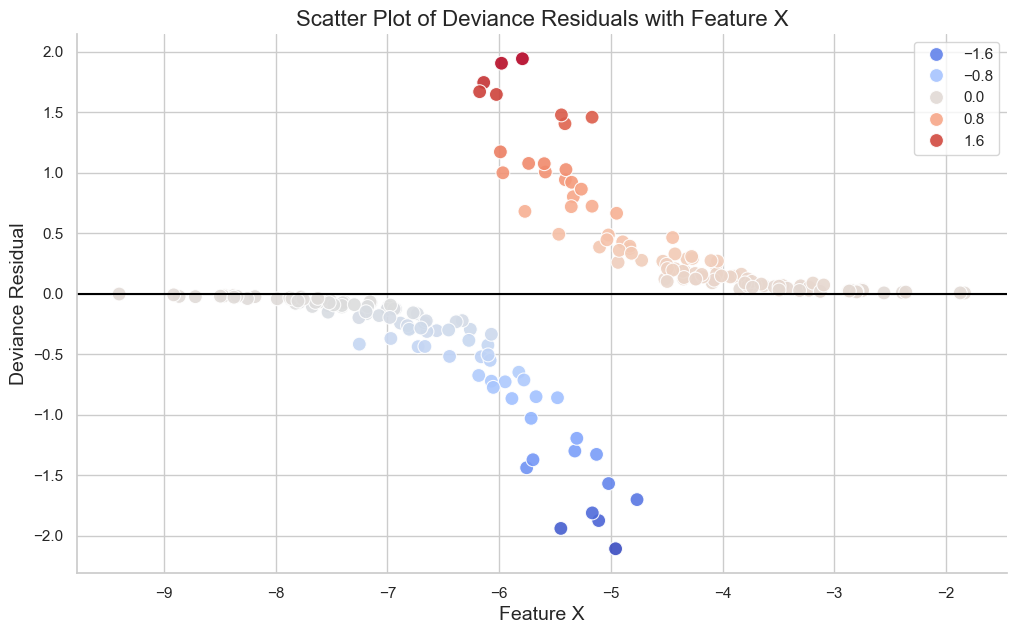

In [415]:
# Improve the aesthetics using seaborn
sns.set(style="whitegrid")

# Isolating feature "x" values for x-axis
x_feature = x_feature = X_test[:, 1]

# Plotting the residuals with 'x' feature on the x-axis
plt.figure(figsize=(12, 7))
sns.scatterplot(x=x_values, y=deviance_residuals, hue=deviance_residuals, palette="coolwarm", s=100, alpha=0.9)

# Drawing a horizontal line at zero
plt.axhline(0, color='black', lw=1.5)

# Labels and title
plt.title('Scatter Plot of Deviance Residuals with Feature X', fontsize=16)
plt.xlabel('Feature X', fontsize=14)
plt.ylabel('Deviance Residual', fontsize=14)

# Removing the top and right spines
sns.despine()

# Show plot
plt.show()


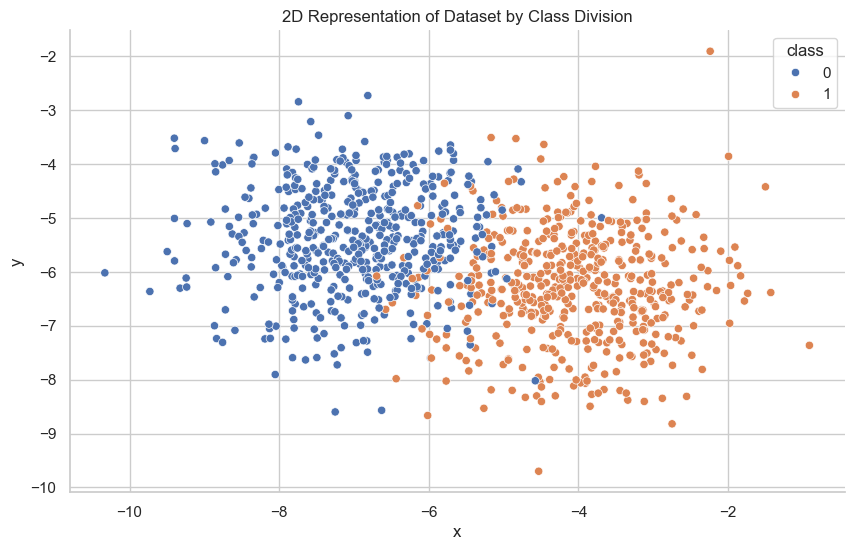

In [416]:
# Scatter plot of the dataset with 'x' and 'y' features, colored by 'class'
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='x', y='y', hue='class')
plt.title('2D Representation of Dataset by Class Division')
sns.despine()
plt.show()

For demonstration purposes, the accompanying plot accentuates a data point labeled index 2, derived from our manual deviance residual calculations. This data point was assigned a high likelihood of belonging to the positive class, with a probability of 0.972, yielding a deviance residual of 0.236. In contrast, another observation with a less certain prediction—assigned a probability of 0.644 and predicted to be positive—was actually from the negative class. According to the calculation, this translates to $1 - 0.644 = 0.356$, and since the logarithm of a number less than 0.5 is negative, the erroneous prediction amplifies the negativity of the residual, resulting in a deviance residual of approximately -1.43. As evident in the plot, this point is situated significantly below the zero line on the negative side, reflecting the magnitude of the prediction error.

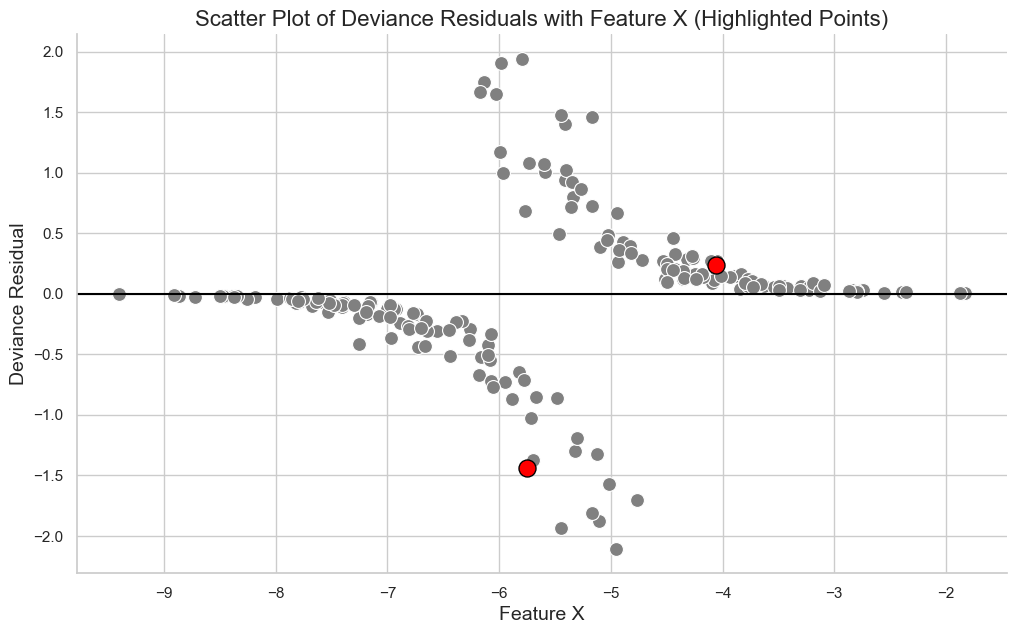

In [417]:
# Highlight the specific data points deviance_residuals[1] and deviance_residuals[2]
highlight = [2, 12]  # Indices of the points to highlight

# Plotting the residuals with 'x' feature on the x-axis
plt.figure(figsize=(12, 7))

# Plot all other points
sns.scatterplot(x=np.delete(x_feature, highlight), y=np.delete(deviance_residuals, highlight), 
                color="grey", s=100)

# Highlight the specific points with a different color and marker
sns.scatterplot(x=x_feature[highlight], y=deviance_residuals[highlight], 
                color="red", s=150, marker='o', edgecolor='black')

# Drawing a horizontal line at zero
plt.axhline(0, color='black', lw=1.5)

# Labels and title
plt.title('Scatter Plot of Deviance Residuals with Feature X (Highlighted Points)', fontsize=16)
plt.xlabel('Feature X', fontsize=14)
plt.ylabel('Deviance Residual', fontsize=14)

# Removing the top and right spines
sns.despine()

# Show plot
plt.show()


In [418]:
model_no_z_test.predict()[12]

0.6440199358830478

In [419]:
deviance_residuals[12]

-1.4372755820437704

In [420]:
y_test[12]

array([0])

In [421]:
# Calculate negative class deviance residual for observation indexed 12
print(-np.sqrt(-2 * (np.log(1 - 0.6440199358830478))))

-1.4372755820437704


### <a id='toc5_2_7_'></a>[Decision Boundary](#toc0_)
The decision boundary delineates the classifier's threshold between the two predicted classes. Data points (observations) are displayed for Feature X and Feature Y, where the gradient transition area around the boundary signifies a shift from a higher likelihood of one class to another.

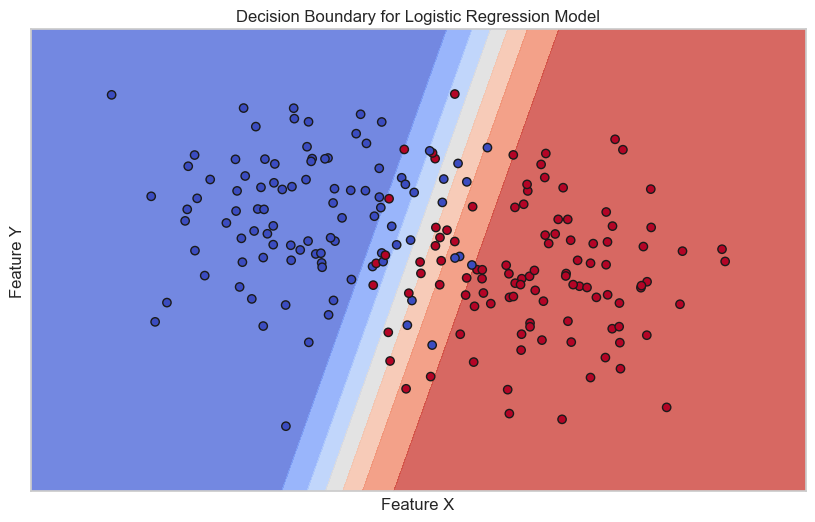

In [422]:
# Retrieve pre-calculated deviance residuals from model excluding Z-scores
from sklearn.inspection import DecisionBoundaryDisplay

# Define the boundaries for the plot
x_min, x_max = X_test_no_z[:, 1].min() - 1, X_test_no_z[:, 1].max() + 1
y_min, y_max = X_test_no_z[:, 2].min() - 1, X_test_no_z[:, 2].max() + 1

# Create a mesh grid to plot decision boundaries
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict over the mesh
mesh_preds = model_no_z_test.predict(sm.add_constant(np.c_[xx.ravel(), yy.ravel()]))

# Reshape predictions to match mesh grid shape
mesh_preds = mesh_preds.reshape(xx.shape)

# Plot decision boundaries
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, mesh_preds, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot test points
plt.scatter(X_test_no_z[:, 1], X_test_no_z[:, 2], c=y_test, cmap=plt.cm.coolwarm, edgecolors='k')
plt.xlabel('Feature X')
plt.ylabel('Feature Y')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("Decision Boundary for Logistic Regression Model")
plt.show()

### <a id='toc5_2_8_'></a>[Log Loss Explained / Binary Cross Entropy](#toc0_)

Log Loss, or binary cross entropy, measures a classification model's accuracy. It's given by the formula:

$\text{Log Loss} = -\frac{1}{N}\sum[y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y})]$

- $N$ is the number of samples.
- $y$ is the actual label.
- $\hat{y}$ is the predicted probability.

A lower Log Loss indicates more accurate predictions, penalizing false confidence heavily.

See a full explanation [here](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).

In [423]:
from sklearn.metrics import log_loss

# Predicting probabilities
y_pred_no_z_test = model_no_z_test.predict(X_test_no_z)  # .predict_proba for sklearn

# Calculating log loss
loss = log_loss(y_test, y_pred_no_z_test)

# print('x = {}'.format(X_test_no_z))
# print('y = {}'.format(y_test))
# print('p(y) = {}'.format(np.round(y_pred_no_z_test, 2)))
print('\nLog Loss / Cross Entropy = {:.4f}'.format(loss))



Log Loss / Cross Entropy = 0.1907


# <a id='toc6_'></a>[Summary](#toc0_)
In summary, our logistic regression notebook encapsulated the following learnings:

- Generating and visualizing the dataset in three dimensions.
- Preprocessing steps, including train/test splitting and reshaping.
- Constructing and fine-tuning logistic regression models with `sklearn`.
- Evaluation using confusion matrices, classification reports, and ROC-AUC analysis.

In-depth technical exploration conducted with `statsmodels.api` encompassed:

- Comparing full and reduced models via McFadden's R-squared, Log-Likelihood, AIC, and BIC.
- Interpreting coefficients to understand their impact on outcomes in terms of log odds and odds ratios.
- Analyzing marginal effects and the significance of predictor variables.
- Delving into the intricacies of deviance residuals for insightful model diagnostics.
- Visualizing the decision boundary and comprehending the implications of log loss.

These technical aspects have ideally contributed to our nuanced understanding of model performance, aiding in the selection of a robust model that strives to strike a balance between fit and complexity. This balance is important for enhancing predictive accuracy while mitigating the risk of overfitting.


**Questions?**

Feel free to ask any questions or provide feedback.

<div style="text-align: left;">
<a href="https://freeimage.host/i/HXsIQUv"><img src="https://iili.io/HXsIQUv.md.jpg" alt="HXsIQUv.md.jpg" border="0" width="450"></a>
</div>